# FARE Evaluation: Comparison of Fair Ranking Methods

**Author:** Caitlin Kuhlman
    
This notebook contains the experimental evaluation performing audits of state-of-the-art fair ranking methods included in the paper:

Caitlin Kuhlman, MaryAnn VanValkenburg, Elke Rundensteiner. "FARE: Diagnostics for Fair Ranking using Pairwise Error Metrics" in the proceedings of the Web Conference (WWW 2019)


These experiments replicate the work in the paper:
Meike Zehlike, Francesco Bonchi, Carlos Castillo, Sara Hajian, Mohamed Megahed and Ricardo Baeza-Yates. FA*IR: A Fair Top-k Ranking Algorithm. CIKM 2017.

We replcated their experiments using the data and code here: https://github.com/MilkaLichtblau/FA-IR_Ranking


### Methods

We evaluate the FARE methodology by auditing state-of-the-art post-processing techniques designed to correct existing rankings. Two fair ranking methods which enforce statistical parity notions of fairness are compared.

1. **Baseline:**
We just predict the rankings according to the original scores. This lets us analyze the statistical parity of the original list. there will be no errors for equalized odds or calibration.

2. **Feldman:** 
The Feldman method is proposed by Feldman et al. in the paper "Certifying and removing disparate impact."(KDD 2015) as pre-processing step for fair classification in which data are ranked. In this method the utility scores for objects in the minority group are adjusted to match the distribution of the majority. We compare these rankings against a baseline of the true ranking with no correction. We use the implementation provided by Zehlike et al. 

3. **FA\*IR #:**
“FA\*IR” rankings are generated using a greedy algorithm proposed by Zehlike et al. The rankings target a user-specified minimum proportion of the minority group, subject to a statistical significance test. The proportion is indicated in the method name, e.g., FA*IR2 for 20\%. Here we use the same proportions as the authors, chosen to be close to the actual group ratio over the entire dataset.  

### Datasets.

**Statlog German Credit Dataset**
is available from the UCI Library https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) provides a "ground truth" ranking of people  according to their credit-worthiness for our experiments. Three "fair" rankings are then created using *age < 25*, *age < 35* and *gender = female* as protected group attributes. Prefix rankings with *k = 100* are generated. 

**COMPAS recidivism dataset**
was published by ProPublica in their investigation of racial bias in the criminal justice system.  https://github.com/propublica/compas-analysis
This dataset is ranked according to COMPAS scores indicating the likelihood of re-offending for the "true" ranking with *k=1000*. "Fair" rankings are generated according to groups *race = African American* and *gender = male*. 

### Metrics 
We produce audit plots using our proposed metrics $Req, Rcal$ and $Rpar$, and summarize the results using FARE distance diagnostics.


In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as random
from fare.metrics import rank_parity, rank_calibration, rank_equality
from fare.audit import audit_parity, audit_calibration, audit_equality, generate_diagnostics, plot_audit
from convert_FA_IR import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ranking of german credit with 100 datapoints
# age<25 as protected attribute
ger1_25 = getAllFA_IRData('data/processed/fa_ir_german_credit100/GermanCreditAge25',formatRank_german)
# age<35 as protected attribute
ger1_35 = getAllFA_IRData('data/processed/fa_ir_german_credit100/GermanCreditAge35',formatRank_german)
# gender=female as protected attribute
ger1_g = getAllFA_IRData('data/processed/fa_ir_german_credit100/GermanCreditSex',formatRank_german)
# ranking of compass dataset using gender as protected attribute
compas_gender = getAllFA_IRData('data/processed/fa_ir_compas_gender1000/CompasGender',formatRank_compas)

# ranking of compass dataset using race as protected attribute
compas_race = getAllFA_IRData('data/processed/fa_ir_compas_race1000/CompasRace',formatRank_compas)

In [3]:
window= 30
step =10

def getdist(window, step, df, name):
    
    diag = pd.DataFrame(index=['Rpar','Rcal','Req'])
    stats=[]
    
    err0, err1 = audit_parity(df['y_pred'], df['g'], window, step)
    diffs = np.abs(np.array(err0) - np.array(err1))
    stats.append(np.mean(diffs))
        
    err0, err1 = audit_calibration(df['y'], df['y_pred'], df['g'], window, step)
    diffs = np.abs(np.array(err0) - np.array(err1))
    stats.append(np.mean(diffs))
    
    err0, err1 = audit_equality(df['y'], df['y_pred'], df['g'], window, step)
    diffs = np.abs(np.array(err0) - np.array(err1))
    stats.append(np.mean(diffs))  
    


    diag[name]=stats
    return diag.round(2)

def getstats(data, fair, w, s):

    df = getdist(w, s, data['base'], "base")
    df = pd.concat([df, getdist(w, s, data['feld'], 'feld')], axis=1)
    df = pd.concat([df, getdist(w, s, data[fair], fair)], axis=1)
    return df

,Rpar,Rcal,Req
base,0.17,0.00,0.00
feld,0.04,0.06,0.26
fair6,0.04,0.04,0.40


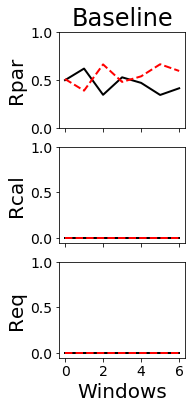

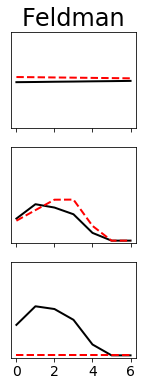

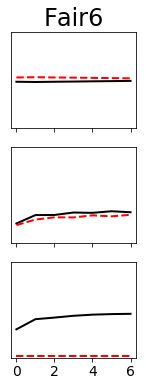

In [4]:
w= 30
s =10

# German Credit age <35
plot_audit(ger1_35['base']['y'], ger1_35['base']['y_pred'], ger1_35['base']['g'], w, s, "Baseline", "charts/ger1_35_b.pdf")
plot_audit(ger1_35['feld']['y'], ger1_35['feld']['y_pred'], ger1_35['feld']['g'], w, s, "Feldman", "charts/ger1_35_f.pdf", label=False)
plot_audit(ger1_35['fair6']['y'], ger1_35['fair6']['y_pred'], ger1_35['fair6']['g'], w, s, "Fair6", "charts/ger1_35_fair2.pdf", label=False)

getstats(ger1_35, 'fair6', w, s).transpose()

,Rpar,Rcal,Req
base,0.25,0.00,0.00
feld,0.03,0.23,0.33
fair2,0.03,0.18,0.27


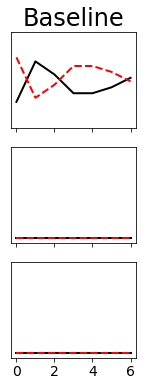

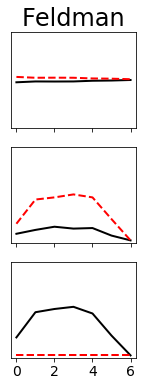

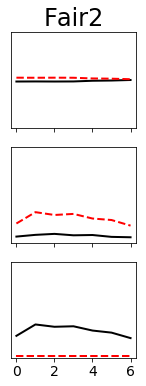

In [5]:
w= 30
s =10

# German Credit age <25
plot_audit(ger1_25['base']['y'], ger1_25['base']['y_pred'], ger1_25['base']['g'], w, s, "Baseline", "charts/ger1_25_b.pdf", label=False)
plot_audit(ger1_25['feld']['y'], ger1_25['feld']['y_pred'], ger1_25['feld']['g'], w, s, "Feldman", "charts/ger1_25_f.pdf", label=False)
plot_audit(ger1_25['fair2']['y'], ger1_25['fair2']['y_pred'], ger1_25['fair2']['g'], w, s, "Fair2", "charts/ger1_25_fair2.pdf", label=False)

getstats(ger1_25, 'fair2', w, s).transpose()

,Rpar,Rcal,Req
base,0.33,0.00,0.00
feld,0.05,0.10,0.27
fair7,0.08,0.11,0.28


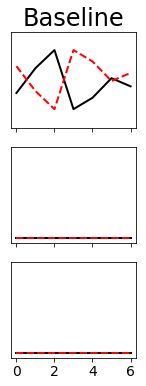

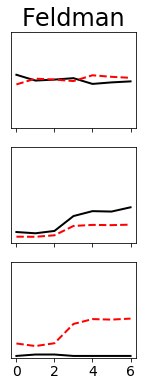

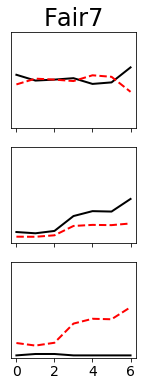

In [6]:
w= 30
s =10

# German Credit gender=f
plot_audit(ger1_g['base']['y'], ger1_g['base']['y_pred'], ger1_g['base']['g'], w, s, "Baseline", "charts/ger1_g_b.pdf", label=False)
plot_audit(ger1_g['feld']['y'], ger1_g['feld']['y_pred'], ger1_g['feld']['g'], w, s, "Feldman", "charts/ger1_g_f.pdf", label=False)
plot_audit(ger1_g['fair7']['y'], ger1_g['fair7']['y_pred'], ger1_g['fair7']['g'], w, s, "Fair7", "charts/ger1_g_fair7.pdf", label=False)

getstats(ger1_g, 'fair7', w, s).transpose()

,Rpar,Rcal,Req
base,0.13,0.00,0.00
feld,0.09,0.03,0.09
fair8,0.02,0.01,0.03


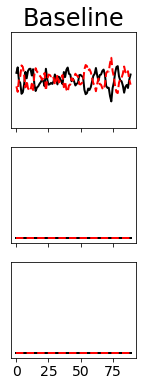

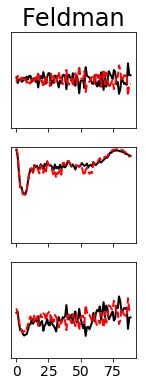

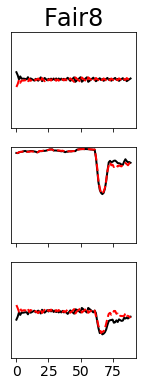

In [7]:
w= 100
s =10

# Compas gender=m

plot_audit(compas_gender['base']['y'], compas_gender['base']['y_pred'], compas_gender['base']['g'], w, s, "Baseline", "charts/compas_gender_b.pdf", label=False)
plot_audit(compas_gender['feld']['y'], compas_gender['feld']['y_pred'], compas_gender['feld']['g'], w, s, "Feldman", "charts/compas_gender_f.pdf", label=False)
plot_audit(compas_gender['fair8']['y'], compas_gender['fair8']['y_pred'], compas_gender['fair8']['g'], w, s, "Fair8", "charts/compas_gender_fair8.pdf", label=False)

getstats(compas_gender, 'fair8', w, s).transpose()

,Rpar,Rcal,Req
base,0.09,0.00,0.00
feld,0.08,0.01,0.08
fair5,0.02,0.01,0.04


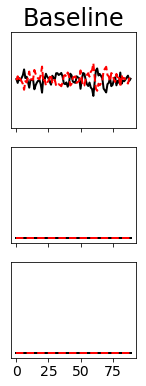

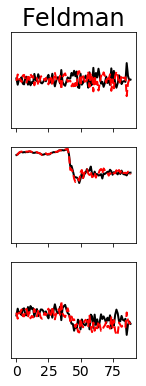

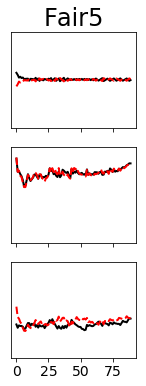

In [8]:
w= 100
s =10

# Compas race=aa

plot_audit(compas_race['base']['y'], compas_race['base']['y_pred'], compas_race['base']['g'], w, s, "Baseline", "charts/compas_race_b.pdf", label=False)
plot_audit(compas_race['feld']['y'], compas_race['feld']['y_pred'], compas_race['feld']['g'], w, s, "Feldman", "charts/compas_race_f.pdf", label=False)
plot_audit(compas_race['fair5']['y'], compas_race['fair5']['y_pred'], compas_race['fair5']['g'], w, s, "Fair5", "charts/compas_race_fair5.pdf", label=False)

getstats(compas_race, 'fair5', w, s).transpose()